In [ ]:
!pip install tensorflow scikit-learn

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Time Series Project/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Time Series Project/Dataset/calendar.csv
/content/drive/MyDrive/Time Series Project/Dataset/sales_train_evaluation.csv
/content/drive/MyDrive/Time Series Project/Dataset/sample_submission.csv
/content/drive/MyDrive/Time Series Project/Dataset/sales_train_validation.csv
/content/drive/MyDrive/Time Series Project/Dataset/sell_prices.csv


In [27]:
sell_prices = pd.read_csv('/content/drive/MyDrive/Time Series Project/Dataset/sell_prices.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Time Series Project/Dataset/sample_submission.csv')
calendar = pd.read_csv('/content/drive/MyDrive/Time Series Project/Dataset/calendar.csv')
sales_train_validation = pd.read_csv('/content/drive/MyDrive/Time Series Project/Dataset/sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('/content/drive/MyDrive/Time Series Project/Dataset/sales_train_evaluation.csv')

In [ ]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


##Pre-processing data for Single Store Sale prediction

In [28]:
numerical_columns = sales_train_validation.select_dtypes(include=['number'])
numerical_columns.groupby(sales_train_validation['store_id']).sum()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,4440,5352,5760,3830,3631,3691,3303,4457,5884,6082
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,5337,6936,8271,6068,5683,5235,5018,5623,7419,7721
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2496,2839,3047,2809,2677,2500,2458,2628,2954,3271
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3084,3724,4192,3410,3257,2901,2776,3022,3700,4033
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,...,3897,4475,4998,3311,3727,3384,3446,3902,4483,4292
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,...,3819,4261,4519,3147,3938,3315,3380,3691,4083,3957
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,3862,4862,4812,3236,3069,3242,3324,3991,4772,4874
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,6259,5579,5566,4347,4464,4194,4393,4988,5404,5127


In [29]:
#Aggregate by the store level for now
numerical_columns = sales_train_validation.select_dtypes(include=['number'])
store_level = numerical_columns.groupby(sales_train_validation['store_id']).sum()
store_levelt = store_level.transpose()
store_levelt['d'] = store_levelt.index
store_levelt

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,d
d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,d_1
d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,d_2
d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,d_3
d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,d_4
d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,d_5
...,...,...,...,...,...,...,...,...,...,...,...
d_1909,3722,3691,5235,2500,2901,3384,3315,3242,4194,3159,d_1909
d_1910,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226,d_1910
d_1911,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828,d_1911
d_1912,5577,5884,7419,2954,3700,4483,4083,4772,5404,4686,d_1912


In [30]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [31]:
#Merge this with the calendar data set to look at trends
store_level_final = store_levelt.merge(calendar, on='d')
from datetime import datetime
store_level_final['date'] = store_level_final['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))
store_level_final

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,3722,3691,5235,2500,2901,3384,3315,3242,4194,3159,...,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226,...,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828,...,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,5577,5884,7419,2954,3700,4483,4083,4772,5404,4686,...,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


In [32]:
store_level_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CA_1          1913 non-null   int64         
 1   CA_2          1913 non-null   int64         
 2   CA_3          1913 non-null   int64         
 3   CA_4          1913 non-null   int64         
 4   TX_1          1913 non-null   int64         
 5   TX_2          1913 non-null   int64         
 6   TX_3          1913 non-null   int64         
 7   WI_1          1913 non-null   int64         
 8   WI_2          1913 non-null   int64         
 9   WI_3          1913 non-null   int64         
 10  d             1913 non-null   object        
 11  date          1913 non-null   datetime64[ns]
 12  wm_yr_wk      1913 non-null   int64         
 13  weekday       1913 non-null   object        
 14  wday          1913 non-null   int64         
 15  month         1913 non-null   int64   

(array([15006., 15013., 15020., 15027., 15034., 15041., 15048.]),
 [Text(15006.0, 0, '2011-02-01'),
  Text(15013.0, 0, '2011-02-08'),
  Text(15020.0, 0, '2011-02-15'),
  Text(15027.0, 0, '2011-02-22'),
  Text(15034.0, 0, '2011-03-01'),
  Text(15041.0, 0, '2011-03-08'),
  Text(15048.0, 0, '2011-03-15')])

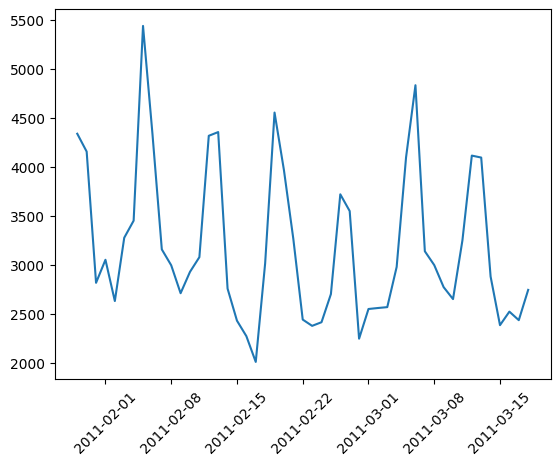

In [33]:
plt.plot(store_level_final['date'][0:49], store_level_final['CA_1'][0:49])
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Saturday'),
  Text(1, 0, 'Sunday'),
  Text(2, 0, 'Monday'),
  Text(3, 0, 'Tuesday'),
  Text(4, 0, 'Wednesday'),
  Text(5, 0, 'Thursday'),
  Text(6, 0, 'Friday')])

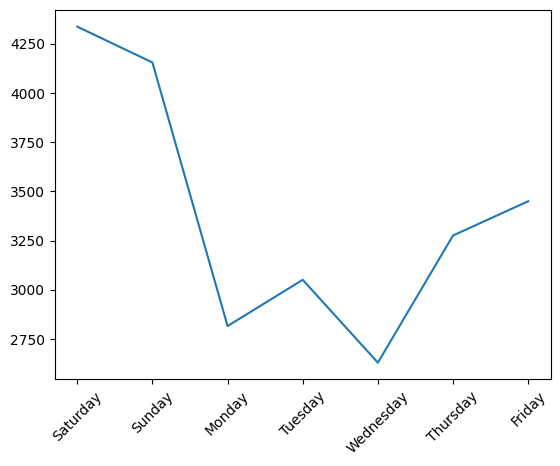

In [34]:
plt.plot(store_level_final['weekday'][0:7], store_level_final['CA_1'][0:7])
plt.xticks(rotation=45)

In [35]:
scaler = MinMaxScaler()
store_level_final['CA_1'] = scaler.fit_transform(store_level_final['CA_1'].values.reshape(-1,1))

In [36]:
# Preparing the data with a window size
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [37]:
window_size = 4
X, y = create_dataset(store_level_final['CA_1'], window_size)

In [38]:
X.shape, y.shape

((1909, 4), (1909,))

In [39]:
# Splitting the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [40]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1527, 4), (1527,), (382, 4), (382,))

In [41]:
# Reshaping data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=32
batch_size_RNN=44
history = regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size_RNN, validation_data=(X_test, y_test))

Epoch 1/32
35/35 [==============================] - 20s 206ms/step - loss: 0.0579 - val_loss: 0.0230
Epoch 2/32
35/35 [==============================] - 3s 90ms/step - loss: 0.0224 - val_loss: 0.0258
Epoch 3/32
35/35 [==============================] - 5s 135ms/step - loss: 0.0215 - val_loss: 0.0204
Epoch 4/32
35/35 [==============================] - 4s 127ms/step - loss: 0.0217 - val_loss: 0.0231
Epoch 5/32
35/35 [==============================] - 4s 105ms/step - loss: 0.0208 - val_loss: 0.0214
Epoch 6/32
35/35 [==============================] - 3s 89ms/step - loss: 0.0215 - val_loss: 0.0188
Epoch 7/32
35/35 [==============================] - 3s 87ms/step - loss: 0.0217 - val_loss: 0.0256
Epoch 8/32
35/35 [==============================] - 4s 112ms/step - loss: 0.0201 - val_loss: 0.0301
Epoch 9/32
35/35 [==============================] - 4s 119ms/step - loss: 0.0202 - val_loss: 0.0214
Epoch 10/32
35/35 [==============================] - 3s 88ms/step - loss: 0.0191 - val_loss: 0.0241
Ep

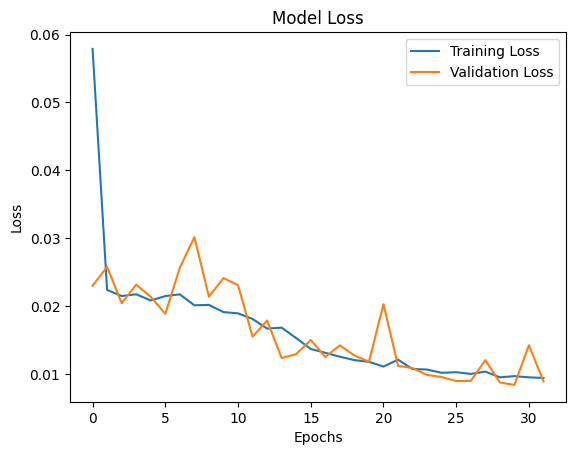

In [43]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
y_pred = regressor.predict(X_test)

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

mae = mean_squared_error(y_test_original, y_pred_original)
print(f'Mean Squared Error: {mae}')

12/12 [==============================] - 1s 19ms/step
Mean Squared Error: 429605.8174751337


In [46]:
import math
rmse = math.sqrt(mae)
rmse

655.4432221597334

##Category Prediction (For Practice)

In [ ]:
numerical_columns = sales_train_validation.select_dtypes(include=['number'])
category_sales = numerical_columns.groupby(sales_train_validation['cat_id']).sum()
category_salest = category_sales.transpose()
category_salest['d'] = category_salest.index
category_salest.head()

cat_id,FOODS,HOBBIES,HOUSEHOLD,d
d_1,23178,3764,5689,d_1
d_2,22758,3357,5634,d_2
d_3,17174,2682,3927,d_3
d_4,18878,2669,3865,d_4
d_5,14603,1814,2729,d_5


In [ ]:
#Merge this with the calendar data set to look at trends
category_level_final = category_salest.merge(calendar, on='d')
from datetime import datetime
category_level_final['date'] = category_level_final['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))
category_level_final

,FOODS,HOBBIES,HOUSEHOLD,d,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,23178,3764,5689,d_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,22758,3357,5634,d_2,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,17174,2682,3927,d_3,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,18878,2669,3865,d_4,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,14603,1814,2729,d_5,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,23632,3472,8239,d_1909,2016-04-20,11612,Wednesday,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,23317,3353,8363,d_1910,2016-04-21,11612,Thursday,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,26704,4085,9728,d_1911,2016-04-22,11612,Friday,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,31927,4787,12248,d_1912,2016-04-23,11613,Saturday,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
scaler = MinMaxScaler()
category_level_final['FOODS'] = scaler.fit_transform(category_level_final['FOODS'].values.reshape(-1,1))
category_level_final['HOBBIES'] = scaler.fit_transform(category_level_final['HOBBIES'].values.reshape(-1,1))
category_level_final['HOUSEHOLD'] = scaler.fit_transform(category_level_final['HOUSEHOLD'].values.reshape(-1,1))

In [ ]:
# Preparing the data with a window size
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

###FOODS

In [ ]:
window_size = 4
X, y = create_dataset(category_level_final['FOODS'], window_size)

# Splitting the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1527, 4, 1), (1527,), (382, 4, 1), (382,))

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=32
batch_size_RNN=44
history = regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size_RNN, validation_data=(X_test, y_test))

Epoch 1/32
35/35 [==============================] - 12s 127ms/step - loss: 0.0569 - val_loss: 0.0168
Epoch 2/32
35/35 [==============================] - 3s 91ms/step - loss: 0.0162 - val_loss: 0.0168
Epoch 3/32
35/35 [==============================] - 4s 114ms/step - loss: 0.0159 - val_loss: 0.0219
Epoch 4/32
35/35 [==============================] - 4s 117ms/step - loss: 0.0168 - val_loss: 0.0178
Epoch 5/32
35/35 [==============================] - 3s 92ms/step - loss: 0.0161 - val_loss: 0.0161
Epoch 6/32
35/35 [==============================] - 3s 91ms/step - loss: 0.0158 - val_loss: 0.0176
Epoch 7/32
35/35 [==============================] - 4s 108ms/step - loss: 0.0155 - val_loss: 0.0197
Epoch 8/32
35/35 [==============================] - 4s 123ms/step - loss: 0.0154 - val_loss: 0.0161
Epoch 9/32
35/35 [==============================] - 3s 89ms/step - loss: 0.0157 - val_loss: 0.0158
Epoch 10/32
35/35 [==============================] - 3s 89ms/step - loss: 0.0153 - val_loss: 0.0178
Epo

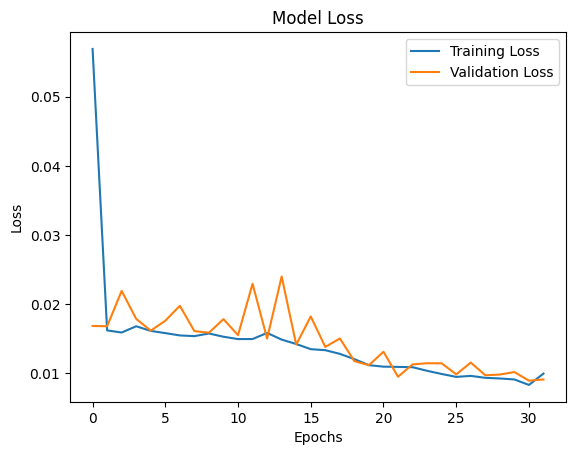

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = regressor.predict(X_test)

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_original, y_pred_original)
print(f'Mean Absolute Error for FOODS: {mae}')

12/12 [==============================] - 0s 21ms/step
Mean Absolute Error for FOODS: 1007.925040753321


Hobbies

In [ ]:
window_size = 4
X, y = create_dataset(category_level_final['HOBBIES'], window_size)

# Splitting the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=32
batch_size_RNN=44
history = regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size_RNN, validation_data=(X_test, y_test))

Epoch 1/32
35/35 [==============================] - 11s 141ms/step - loss: 0.0522 - val_loss: 0.0189
Epoch 2/32
35/35 [==============================] - 5s 134ms/step - loss: 0.0140 - val_loss: 0.0240
Epoch 3/32
35/35 [==============================] - 3s 91ms/step - loss: 0.0138 - val_loss: 0.0214
Epoch 4/32
35/35 [==============================] - 3s 95ms/step - loss: 0.0139 - val_loss: 0.0305
Epoch 5/32
35/35 [==============================] - 3s 94ms/step - loss: 0.0134 - val_loss: 0.0315
Epoch 6/32
35/35 [==============================] - 5s 143ms/step - loss: 0.0138 - val_loss: 0.0223
Epoch 7/32
35/35 [==============================] - 3s 91ms/step - loss: 0.0137 - val_loss: 0.0219
Epoch 8/32
35/35 [==============================] - 3s 91ms/step - loss: 0.0141 - val_loss: 0.0296
Epoch 9/32
35/35 [==============================] - 3s 94ms/step - loss: 0.0137 - val_loss: 0.0330
Epoch 10/32
35/35 [==============================] - 5s 143ms/step - loss: 0.0136 - val_loss: 0.0220
Epoc

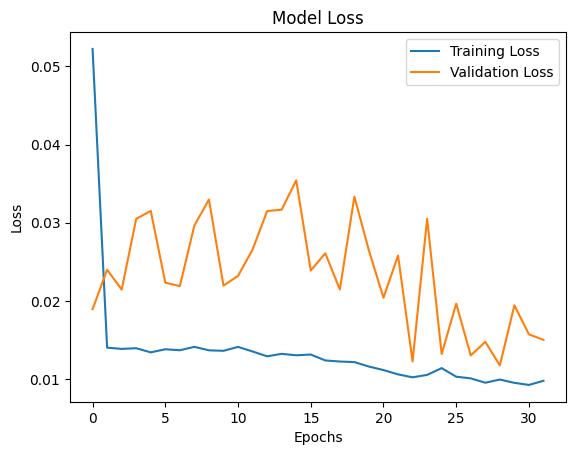

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = regressor.predict(X_test)

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_original, y_pred_original)
print(f'Mean Absolute Error for FOODS: {mae}')

12/12 [==============================] - 2s 33ms/step
Mean Absolute Error for FOODS: 1259.0062034974776


Household

In [ ]:
window_size = 4
X, y = create_dataset(category_level_final['HOUSEHOLD'], window_size)

# Splitting the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=50
regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=400
regressor.add(LSTM(units = layer_3_units))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
epoch_no=32
batch_size_RNN=44
history = regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size_RNN, validation_data=(X_test, y_test))

Epoch 1/32
35/35 [==============================] - 12s 143ms/step - loss: 0.0481 - val_loss: 0.0367
Epoch 2/32
35/35 [==============================] - 3s 94ms/step - loss: 0.0179 - val_loss: 0.0359
Epoch 3/32
35/35 [==============================] - 3s 97ms/step - loss: 0.0181 - val_loss: 0.0306
Epoch 4/32
35/35 [==============================] - 5s 142ms/step - loss: 0.0180 - val_loss: 0.0315
Epoch 5/32
35/35 [==============================] - 3s 93ms/step - loss: 0.0185 - val_loss: 0.0308
Epoch 6/32
35/35 [==============================] - 3s 92ms/step - loss: 0.0181 - val_loss: 0.0553
Epoch 7/32
35/35 [==============================] - 3s 93ms/step - loss: 0.0172 - val_loss: 0.0334
Epoch 8/32
35/35 [==============================] - 5s 150ms/step - loss: 0.0174 - val_loss: 0.0261
Epoch 9/32
35/35 [==============================] - 5s 143ms/step - loss: 0.0168 - val_loss: 0.0339
Epoch 10/32
35/35 [==============================] - 3s 93ms/step - loss: 0.0156 - val_loss: 0.0256
Epoc

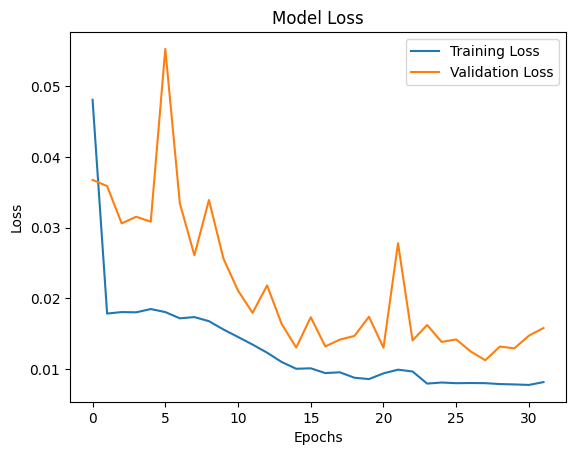

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = regressor.predict(X_test)

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_original, y_pred_original)
print(f'Mean Absolute Error for FOODS: {mae}')

12/12 [==============================] - 1s 21ms/step
Mean Absolute Error for FOODS: 1313.7427652568717
